## Keyword Search Vs Semantic Search

At first, search engines were lexical: the search engine looked for literal matches of the query words, without understanding of the query’s meaning and only returning links that contained the exact query.By using regular keyword search, a document either contains the given word or not, and there is no middle ground

On the other hand, "Semantic Search" can simplify query building, becuase it is supported by automated natural language processing programs i.e. using Latent Semantic Indexing - a concept that search engines use to discover how a keyword and content work together to mean the same thing.

LSI adds an important step to the document indexing process. LSI examines a collection of documents to see which documents contain some of those same words. LSI considers documents that have many words in common to be semantically close, and ones with less words in common to be less close.

In brief, LSI does not require an exact match to return useful results. Where a plain keyword search will fail if there is no exact match, LSI will often return relevant documents that don't contain the keyword at all.



# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import spacy
import string
import gensim
import operator
import re

### Load the data
We will now load the movies data csv into dataframe and quickly peek into the columns and data provided

In [18]:
df_movies = pd.read_csv('movies.csv')
df_movies.head(10)

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
5,5,One Flew Over the Cuckoo's Nest,[u' Drama'],"In 1963 Oregon, Randle Patrick ""Mac"" McMurphy ...","In 1963 Oregon, Randle Patrick McMurphy (Nicho..."
6,6,Gone with the Wind,"[u' Drama', u' Romance', u' War']",\nPart 1\n \n Part 1 Part 1 \n \n On the...,"The film opens in Tara, a cotton plantation ow..."
7,7,Citizen Kane,"[u' Drama', u' Mystery']",\n\n\n\nOrson Welles as Charles Foster Kane\n\...,"It's 1941, and newspaper tycoon Charles Foster..."
8,8,The Wizard of Oz,"[u' Adventure', u' Family', u' Fantasy', u' Mu...",The film starts in sepia-tinted Kansas in the ...,Dorothy Gale (Judy Garland) is an orphaned tee...
9,9,Titanic,"[u' Drama', u' Romance']","In 1996, treasure hunter Brock Lovett and his ...","In 1996, treasure hunter Brock Lovett and his ..."


### Data Cleaning and Pre-processing

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens


Now let us apply the data-cleaning and pre-processing function to our movies "wiki_plot" column and store the cleaned, tokenized data into new column

In [4]:
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['wiki_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head()

Cleaning and Tokenizing...
CPU times: total: 25 s
Wall time: 25.5 s


,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wedding, vito, corleone, hear,..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ..."


Store the tokenized column into a sepearte variable for ease of operations in subsequent sections and have a quick peek into the values

In [5]:
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [day, daughter, wedding, vito, corleone, hear,...
1    [banker, andy, dufresne, convict, murder, wife...
2    [germans, polish, jews, kraków, ghetto, world,...
3    [brief, scene, age, overweight, italian, ameri...
4    [early, december, american, expatriate, rick, ...
Name: wiki_plot_tokenized, dtype: object

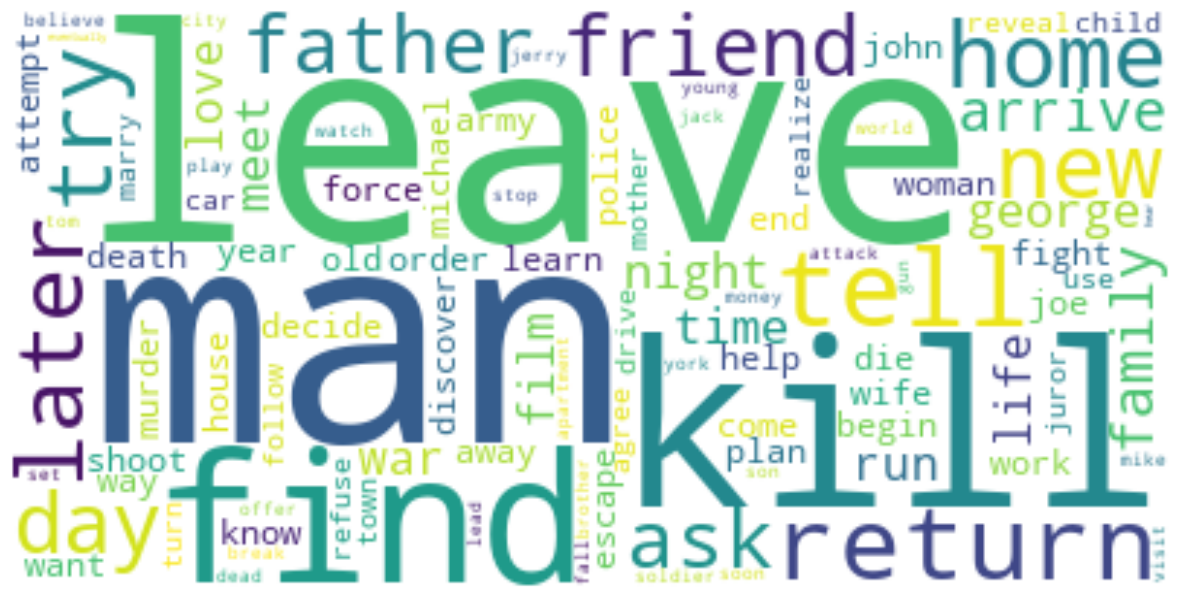

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Building Word Dictionary

In the next step we will build the vocabulary of the corpus in which all the unique words are given IDs and their frequency counds are also stored. You may note that we are using gensim library for building the dictionary.   In gensim, the words are referred as "tokens" and the index of each word in the dictionary is called ID

In [7]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)


CPU times: total: 62.5 ms
Wall time: 52 ms


You can see that there are 2 additional steps performed after creating the dictionary.
1. All the tokens in the dictionary which either have occurrred in less than 4 articles or have occurred in more than 20% of the articles are removed from the dictionary, as these words will not be contributing to the various themes or topics. 
2. Removing content neutral words from the dictionary and additional stopwords.

In [8]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['abrasive', 0], ['abroad', 1], ['abuse', 2], ['accept', 3], ['accuse', 4], ['act', 5], ['adams', 6], ['add', 7], ['address', 8], ['agree', 9], ['ambush', 10], ['angeles', 11], ['answer', 12], ['anthony', 13], ['apollonia', 14], ['arrange', 15], ['ask', 16], ['assassin', 17], ['assassination', 18], ['associate', 19], ['attack', 20], ['attempt', 21], ['authority', 22], ['aware', 23], ['baron', 24], ['barzini', 25], ['battle', 26], ['bed', 27], ['betrayal', 28], ['bodyguard', 29], ['bomb', 30], ['booth', 31], ['brasi', 32], ['brasis', 33], ['break', 34], ['bronx', 35], ['brother', 36], ['business', 37], ['buy', 38], ['capo', 39], ['capos', 40], ['captain', 41], ['car', 42], ['career', 43], ['carlo', 44], ['casino', 45], ['christening', 46], ['christmas', 47], ['clampdown', 48], ['clemenza', 49], ['collapse', 50]]]


### Feature Extraction (Bag of Words)

A bag of words model, or BoW for short is a way of extracting features from text for use in modelling, such as with machine learning algorithms. It is a representation of text that describes the occurence of words within a document. It involves two things

1. A vocabulary of known words
2. A measure of the presence of known words

The doc2bow method of dictionary, iterates through all the words in the text, if the word already exists in the corpus, it increments the frequency count, other wise it inserts the word into the corpus and sets it freqeuncy count to 1

In [9]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('abrasive', 2), ('abroad', 2), ('abuse', 4), ('accept', 6), ('accuse', 2), ('act', 2), ('adams', 3), ('add', 2), ('address', 2), ('agree', 2), ('ambush', 2), ('angeles', 2), ('answer', 2), ('anthony', 3), ('apollonia', 2), ('arrange', 2), ('ask', 2), ('assassin', 4), ('assassination', 4), ('associate', 2), ('attack', 4), ('attempt', 4), ('authority', 2), ('aware', 2), ('baron', 2), ('barzini', 7), ('battle', 2), ('bed', 2), ('betrayal', 2), ('bodyguard', 2), ('bomb', 2), ('booth', 2), ('brasi', 3), ('brasis', 2), ('break', 2), ('bronx', 2), ('brother', 6), ('business', 6), ('buy', 2), ('capo', 1), ('capos', 2), ('captain', 2), ('car', 2), ('career', 2), ('carlo', 7), ('casino', 2), ('christening', 4), ('christmas', 2), ('clampdown', 2), ('clemenza', 3), ('collapse', 2), ('come', 4), ('command', 2), ('confess', 2), ('confront', 2), ('connection', 2), ('connie', 4), ('connies', 2), ('consigliere', 5), ('contact', 2), ('corleone', 10), ('corleones', 4), ('corps', 3), ('coveted', 2), ('

The above results shows vocabulary with their frequency.

### Build Tf-Idf and LSI Model

Tf-Idf means, Term frequency-Inverse Document Frequency. it is a commonly used NLP model that helps you determine the most important words in each document in the corpus. Once the Tf-Idf is build, pass it to LSI model and specify the num of features to build

In [10]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: total: 31.2 ms
Wall time: 23 ms
CPU times: total: 2.84 s
Wall time: 1.14 s


Serialize and Store the corpus locally for easy retrival whenver required.

In [11]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

CPU times: total: 78.1 ms
Wall time: 76 ms
CPU times: total: 62.5 ms
Wall time: 58 ms


In [12]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)


MmCorpus(100 documents, 8400 features, 25983 non-zero entries)
MmCorpus(100 documents, 100 features, 10000 non-zero entries)


In [13]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

CPU times: total: 0 ns
Wall time: 19 ms


## Time for Semantic Search

Now comes the fun part. With the index of movies initialized and loaded, we can use it to find similar movies based


We will input a search query and model will return relevant movie titles with "Relevance %" which is the similarity score. The higher the similarity score, the more similar the query to the documetn at the given index

Below is the helper function to search the index, sort and return the results

In [14]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])


In [15]:
# search for movie tiles that are related to below search parameters
search_similar_movies('crime and drugs ')

,Relevance,Movie Title,Movie Plot
0,81.88,Goodfellas,"Henry Hill (Liotta) admits, ""As far back as I ..."
1,33.94,The French Connection,"In Marseille, an undercover detective is follo..."
2,32.09,The Godfather,"On the day of his only daughter's wedding, Vit..."
3,28.86,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
4,13.16,On the Waterfront,Mob-connected union boss Johnny Friendly (Lee ...


The model returns movie titles with "Relevance %". Definitely, the top list movies are related to crimes and drugs.

In [16]:
# search for movie tiles that are related to below search parameters
search_similar_movies('violence protest march')

,Relevance,Movie Title,Movie Plot
0,74.08,Gandhi,The screenplay of Gandhi is available as a pub...
1,52.19,A Clockwork Orange,"In futuristic London, Alex DeLarge is the lead..."
2,27.03,Amadeus,The story begins in 1823 as the elderly Antoni...
3,24.64,All Quiet on the Western Front,\n\n\n\n\nThis section's plot summary may be t...
4,18.32,The Best Years of Our Lives,"After World War II, Fred Derry (Dana Andrews),..."


Here the top most movie title "Gandhi" is surely related to non-violence protests

In [17]:
# search for movie tiles that are related to below search parameters
search_similar_movies('love affair hate')

,Relevance,Movie Title,Movie Plot
0,45.70,Terms of Endearment,Aurora Greenway (Shirley MacLaine) and her dau...
1,44.78,The Graduate,"Benjamin Braddock, going on from twenty to twe..."
2,30.33,From Here to Eternity,"In 1941, bugler and career soldier Private Rob..."
3,28.83,Out of Africa,"The story begins in 1913 in Denmark, when Kare..."
4,27.63,Wuthering Heights,A traveller named Lockwood (Miles Mander) is c...
